# Open Street Map Data Case Study
By Rachel Foong

**Map Area:** Singapore
Chosen mainly due to its friendly size. One of the smallest countries I could think of and it's close to the country of my origin - Malaysia.

**Data Sources:**
- [OpenStreetMap Relation of Singapore](https://www.openstreetmap.org/relation/536780#map=9/1.3218/104.0687)
- [Metro Extract](https://mapzen.com/data/metro-extracts/metro/singapore/)

**Files used to clean and convert data formats:**<br/>
Most of the code used were taken from Udacity's Data Wrangling class - Case Study Lesson. Others taken from searches via Google which led to many samples from https://stackoverflow.com
- [Produce sample.osm file](https://github.com/redewe/udacity/blob/master/python%20files/Produce+sample+osm+file.py) 
- [Data Auditing and Cleaning](https://github.com/redewe/udacity/blob/master/python%20files/Data_Audit.py)
- [Convert XML file to CSV files for loading into SQLite3](https://github.com/redewe/udacity/blob/master/python%20files/XML+file+to+CSV+files.py)


## Data Overview

In [1]:
#declare all variables
import sqlite3
import pprint, os
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from tabulate import tabulate

folder_PATH="data_input_output"
file_PATH=folder_PATH+"/singapore.db"

In [2]:
#Function to display readable filesize
def GetHumanReadable(size,precision=2):
    suffixes=[' B',' KB',' MB',' GB',' TB']
    suffixIndex = 0
    while size > 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

theFiles = list(os.listdir(folder_PATH))

#Calculate size for all files here. 
theDict = dict()
for something in theFiles: 
    try:
        new_path = folder_PATH+"\\"+something
        theStats = os.stat(new_path)
        theDict[something] = theStats
    except Exception as e:
        print(e)

#Display list of files and filesize
print("File Names and Sizes", "\n++++++++++++++++++++++++")
for item in theDict:
    print("{:30s} {:s}".format(item,GetHumanReadable(theDict[item].st_size)))

File Names and Sizes 
++++++++++++++++++++++++
nodes.csv                      118.59 MB
nodes_tags.csv                 4.90 MB
sample.osm                     9.24 MB
singapore.db                   255.52 MB
singapore.osm                  328.98 MB
ways.csv                       13.55 MB
ways_nodes.csv                 43.46 MB
ways_tags.csv                  21.44 MB


- Number of nodes: 1,517,456
- Number of ways: 237,891
- Number of unique users: 2,178

In [3]:
#Enquire database
db = sqlite3.connect(file_PATH)
c = db.cursor()
c.execute("SELECT e.user as User, COUNT(*) as Num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user ORDER BY Num DESC LIMIT 10;")
rows = c.fetchall()

#Print results
print("Top 10 contributing users", "\n++++++++++++++++++++++++")
print(tabulate(rows, headers='keys', tablefmt='psql'))

Top 10 contributing users 
++++++++++++++++++++++++
+---------------+--------+
| 0             |      1 |
|---------------+--------|
| JaLooNz       | 404899 |
| berjaya       | 117377 |
| rene78        |  77581 |
| cboothroyd    |  72204 |
| lmum          |  51342 |
| kingrollo     |  39063 |
| Luis36995     |  38821 |
| ridixcr       |  38239 |
| Sihabul Milah |  37160 |
| calfarome     |  32945 |
+---------------+--------+


## Problems Encountered with Data

### Issue #1: Cultural issues
- Language Inconsistency - some were in English, others in Chinese. Street names were a mixture of Malay and English e.g. *Jalan* is Malay for road. I've included a list of other Malay names into the expected list of words during the audit process in the Python File [Data Auditing and Cleaning](https://github.com/redewe/udacity/blob/master/python%20files/XML+file+to+CSV+files.py)


### Issue #2.a: User entry issues - keys
- Alternative keys for the same value were discovered e.g. name_1, name_2, building_1 Full list as below taken from the Python file mentioned above
- Some of the keys were also tagged as "FIXME" which meant that the data was incomplete
- While there was a tag for address, the keys like *Jalan* which is Malay for road was also used as a tag on its own. Proof of this can be found in [Data Auditing and Cleaning](https://github.com/redewe/udacity/blob/master/python%20files/XML+file+to+CSV+files.py)

### Issue #2.b: User entry issues - unnecessary "yes" value for buildings
- While not really a major issue, 77% of the values in the data for buildings are just "yes" rather than the type of building it is. Cleaning this would perhaps reduce the file size by removing 92,677 lines of code. 

In [4]:
#Find percentage of keys with latitude/longitude in nodes_tags 
c.execute("SELECT tags.value as Building_Value, COUNT(*) as count "\
          "FROM (SELECT key, value FROM nodes_tags UNION ALL SELECT key, value FROM ways_tags) tags "\
          "WHERE tags.key ='building'  " \
          "GROUP BY tags.value " \
          "ORDER BY count DESC " \
          ";")
Buildings = DataFrame(c.fetchall())
Buildings.columns = map(lambda x: x[0], c.description)
Buildings['pct'] = Buildings['count'] / Buildings['count'].sum()
print("ORIGINAL OUTPUT (Top 15 results)\n",tabulate(Buildings.head(15), headers='keys', tablefmt='psql'))

ORIGINAL OUTPUT (Top 15 results)
 +----+------------------+---------+-------------+
|    | Building_Value   |   count |         pct |
|----+------------------+---------+-------------|
|  0 | yes              |   92677 | 0.766382    |
|  1 | house            |   13458 | 0.111289    |
|  2 | residential      |    5333 | 0.0441006   |
|  3 | terrace          |    2792 | 0.0230881   |
|  4 | apartments       |    2582 | 0.0213515   |
|  5 | industrial       |    1125 | 0.00930306  |
|  6 | commercial       |     951 | 0.00786418  |
|  7 | school           |     591 | 0.00488721  |
|  8 | roof             |     360 | 0.00297698  |
|  9 | construction     |     162 | 0.00133964  |
| 10 | detached         |      93 | 0.000769053 |
| 11 | warehouse        |      81 | 0.00066982  |
| 12 | retail           |      75 | 0.000620204 |
| 13 | office           |      67 | 0.000554049 |
| 14 | train_station    |      66 | 0.000545779 |
+----+------------------+---------+-------------+


### Issue #2.c: User entry issues - cities
- One of the main issues is in the inconsistent naming of cities where the use of lower and upper case is inconsistent. 
- After cleaning for inconsistent case, while only that less than 1% are not actually cities, more than 44% of the cities are actually outside of Singapore. (*This contradicts the lat and lon data that's present in the nodes table which suggests only 27% of the data is outside of Singapore*)

In [5]:
#Find percentage of keys with cities are in nodes_tags 
c.execute("SELECT tags.value as City, COUNT(*) as count "\
          "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "\
          "WHERE tags.key='city' " \
          "GROUP BY tags.value " \
          "ORDER BY count DESC " \
          ";")
cities = DataFrame(c.fetchall())
cities.columns = map(lambda x: x[0], c.description)
print("ORIGINAL OUTPUT (Top 15 results)\n",tabulate(cities.head(15), headers='keys', tablefmt='psql'))

ORIGINAL OUTPUT (Top 15 results)
 +----+-----------------+---------+
|    | City            |   count |
|----+-----------------+---------|
|  0 | Singapore       |   16766 |
|  1 | Johor Bahru     |   13847 |
|  2 | Pasir Gudang    |     168 |
|  3 | Batam           |      43 |
|  4 | SKUDAI          |      36 |
|  5 | Masai           |      14 |
|  6 | Ulu Tiram       |      10 |
|  7 | Iskandar Puteri |       8 |
|  8 | Skudai          |       7 |
|  9 | singapore       |       6 |
| 10 | Kulai           |       4 |
| 11 | Sembawang       |       4 |
| 12 | Nusajaya        |       3 |
| 13 | Batam Kota      |       2 |
| 14 | Gelang Patah    |       2 |
+----+-----------------+---------+


In [6]:
#clean_cities = pd.concat([cities[col][0].lower() for col in cities.columns], axis=1)
clean_cities = pd.concat([cities['City'].apply(lambda x: x.lower()), cities['count']], axis =1)

result = clean_cities.groupby('City').sum().sort_values('count', axis=0, ascending=False)
result['pct'] = result['count'] / result['count'].sum()
print("AFTER CLEANING (Top 15 results) \n",tabulate(result.head(15), headers='keys', tablefmt='psql'))

AFTER CLEANING (Top 15 results) 
 +--------------------+---------+-------------+
| City               |   count |         pct |
|--------------------+---------+-------------|
| singapore          |   16772 | 0.541661    |
| johor bahru        |   13851 | 0.447326    |
| pasir gudang       |     168 | 0.00542566  |
| batam              |      43 | 0.00138871  |
| skudai             |      43 | 0.00138871  |
| masai              |      14 | 0.000452138 |
| ulu tiram          |      10 | 0.000322956 |
| iskandar puteri    |       8 | 0.000258365 |
| sembawang          |       4 | 0.000129182 |
| kulai              |       4 | 0.000129182 |
| nusajaya           |       3 | 9.68867e-05 |
| batam kota         |       3 | 9.68867e-05 |
| gelang patah       |       2 | 6.45911e-05 |
| taman bukit dahlia |       1 | 3.22956e-05 |
| medini             |       1 | 3.22956e-05 |
+--------------------+---------+-------------+


### Issue #3: Map boundary issues
- As the map below shows, quite a significant amount of points lay outside of Singapore island itself 

In [7]:
#Find all lat,long points in data
c.execute("SELECT lat As Latitude, lon as Longitude FROM nodes;")
""
party = DataFrame(c.fetchall())
party.columns = map(lambda x: x[0], c.description)

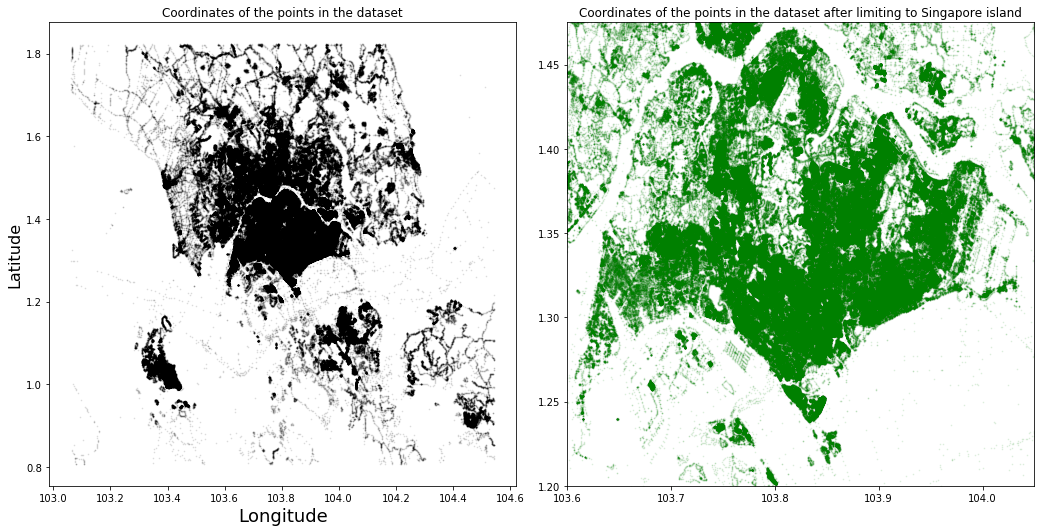

Roughly 27% of points are outside Singapore's boundaries


In [8]:
#Code taken from https://www.kaggle.com/somesnm/new-york-parties-eda 
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
plt.subplot(1, 2, 1)
ax = plt.scatter(party['Longitude'].values, party['Latitude'].values,
              color='black', s=0.5, label='train', alpha=0.1)
ax.axes.set_title('Coordinates of the points in the dataset')
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=16)
ax.figure.set_size_inches(6,5)

#Project zoomed in map with limits
plt.subplot(1, 2, 2)
city_long_border = (103.6,104.05)
city_lat_border = (1.2, 1.475)
ax = plt.scatter(party['Longitude'].values, party['Latitude'].values,
              color='green', s=0.5, label='train', alpha=0.1)
ax.axes.set_title('Coordinates of the points in the dataset after limiting to Singapore island')
ax.figure.set_size_inches(15,7.5)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.tight_layout()
plt.show()

#Find percentage of long/lat points that are outside of Singapore island
c.execute("SELECT COUNT(*) *100/ (SELECT COUNT(*) FROM nodes)  FROM nodes WHERE (lat >= 1.2 AND lat <= 1.475) AND (lon >= 103.6 AND lon <= 104.05);")
print("Roughly","{0:.0f}%".format(100-c.fetchall()[0][0]),"of points are outside Singapore's boundaries")

## Other ideas about the dataset

- To improve the dataset, it's best if the OSM data automatically filters for points outside the boundaries of any given country/city. Alternatively, the data points out of Singapore can be in a supplementary file that can be combined with the cleaned file. 
    - **Methods**
        - This can be achieved possibly by cross-referencing a Singapore address database like [easypost](https://www.easypost.com/singapore-address-verification.html). 
            - Issue with this is that matching the user entered addresses in the OSM file with the style and structure in the database may prove difficult as styles/structures may change and therefore regular code changes may be required.
            - Not all points on the map have addresses as well. 
        - Gamification can also be used for validating and regular cleaning of the data or a "name and shame" where users who submitted points outside of the map are blacklisted to prevent recurring problems.
        - Similar to Creative Commons Licensing, apps or websites who use data from the OSM file should also give credit to the users who contributed to it. 
    - **Benefits**
        - Helps in data validation and allows apps or websites that is dependent on Singapore coordinates to speed up in terms of loading the data.
        - Over time, the hope is that a self-regulated community of users develop of whom are proud about the data that is being added to the dataset when they see their data being used by businesses and non-profits alike. 


In [9]:
db.close()